### Importing and Installing Libraries

In [247]:
# Libraries used to load dataframe and visualize data
import numpy as np 
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz
import plotly.io as pio
pio.renderers.default='notebook'
%matplotlib inline

# Noise removal helper libraries
import re
import string 
from stopwordsiso import stopwords as sw
from nltk.corpus import stopwords

# Text Preprocessing
from nltk.tokenize import TweetTokenizer
from nltk import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Feature Engineering and Data preparation for modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Model building and training
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

#save the final model and vectorizer
import pickle

### Load Training Data

In [248]:
# Load the training and test dataset
train_data = pd.read_csv('train.csv')
train= pd.read_csv('train.csv')
test_data=pd.read_csv('test_with_no_labels.csv')
test=pd.read_csv('test_with_no_labels.csv')

In [249]:
train_data.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [250]:
test_data.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


###  Noise Removal

In [251]:
def text_preprocessing (df_text):
    
    # Regex pattern for url addresses
    pattern_url = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
    
    # Regex patter for numerical values
    pattern_digits = r'\d+'
    
    # Regex pattern for twitter handles
    pattern_handles = r'@(\w+)'

    # removing website addresses
    df_text['message'] = df_text['message'].replace(to_replace = pattern_url, value = '', regex = True)
    
    # removing digits 
    df_text['message'] = df_text['message'].replace(to_replace = pattern_digits, value = '', regex = True)
    # removing handles
    df_text['message'] = df_text['message'].replace(to_replace = pattern_handles, value = '', regex = True)
    
    # convering text to lowercase
    low = lambda tweets: ''.join([tweet.lower() for tweet in tweets])
    df_text['message'] = df_text['message'].apply(low) # The low function is used convert values in the message column to lowercase
    
    # removeing punctuation from a dataframe
    punct = lambda tweets: ''.join([tweet for tweet in tweets if tweet not in string.punctuation])
    df_text['message'] = df_text['message'].apply(punct)# The punct function is used ot remove punctuation from the message column
    
    #removing non-ascii characters from the message column in the dataframe
    df_text.message.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
    
    return df_text

In [252]:
clean_train = text_preprocessing(train_data)
clean_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt researchers say we have three years to act...,698562
3,1,todayinmaker wired was a pivotal year in the...,573736
4,1,rt its and a racist sexist climate change de...,466954


In [253]:
clean_test = text_preprocessing(test_data)
clean_test.head()

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffers re c...,35326
2,the scary unimpeachable evidence that climate ...,224985
3,\nputin got to you too jill \ntrump doesn...,476263
4,rt female orgasms cause global warming\nsarca...,872928


### Tokenisation  

In [254]:
def tokens(df_text, column_name):
    
    # Instantiate TweetTokenizer
    tknzr = TweetTokenizer(reduce_len = True)
    
    # Format the message column using TweetTokenizer
    df_text[column_name] = df_text[column_name].apply(tknzr.tokenize)
    
    return df_text

In [255]:
tokens_train = tokens(clean_train, 'message')
tokens_train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, doesnt, think, carb...",625221
1,1,"[its, not, like, we, lack, evidence, of, anthr...",126103
2,2,"[rt, researchers, say, we, have, three, years,...",698562
3,1,"[todayinmaker, wired, was, a, pivotal, year, i...",573736
4,1,"[rt, its, and, a, racist, sexist, climate, cha...",466954


In [256]:
tokens_test = tokens(clean_test, 'message')
tokens_test.head()

,message,tweetid
0,"[europe, will, now, be, looking, to, china, to...",169760
1,"[combine, this, with, the, polling, of, staffe...",35326
2,"[the, scary, unimpeachable, evidence, that, cl...",224985
3,"[putin, got, to, you, too, jill, trump, doesnt...",476263
4,"[rt, female, orgasms, cause, global, warming, ...",872928


### Stopwords Removal

In [257]:
def stop(df_text, column_name):
    
    # fuction that returns tokenized words which are not 'rt'
    rt = lambda tweets: [tweet for tweet in tweets if tweet != 'rt']
    
    # removing all 'rt'instances from each observation
    df_text[column_name] = df_text[column_name].apply(rt)
    
    # words in a tokenized dataframe that do not appear in a stopwords set
    stops = lambda tweets: [tweet for tweet in tweets if tweet not in sw('en')]
    
    # removing all stopwords from the dataframe
    df_text[column_name] = df_text[column_name].apply(stops)
    
    return df_text

In [258]:
stops_test = stop(tokens_test, 'message')
stops_test.head()

,message,tweetid
0,"[europe, china, fighting, climate, change]",169760
1,"[combine, polling, staffers, climate, change, ...",35326
2,"[scary, unimpeachable, evidence, climate, chan...",224985
3,"[putin, jill, trump, climate, change, hoax]",476263
4,"[female, orgasms, global, warming, sarcastic, ...",872928


In [259]:
stops_train = stop(tokens_train, 'message')
stops_train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, carbon, dioxide, ma...",625221
1,1,"[lack, evidence, anthropogenic, global, warming]",126103
2,2,"[researchers, climate, change, late]",698562
3,1,"[todayinmaker, wired, pivotal, war, climate, c...",573736
4,1,"[racist, sexist, climate, change, denying, big...",466954


###  Lemmatizaton

In [260]:
# Instantiate WordNetLemmatizer as lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatized dataframe  using the stops_train dataframe
lemmatized_train = stops_train.copy()

# Using lemmatizer on the message column 
lemmatized_train['message'] = stops_train['message'].apply(lambda sentence : [lemmatizer.lemmatize(word) for word in sentence])

lemmatized_train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, carbon, dioxide, ma...",625221
1,1,"[lack, evidence, anthropogenic, global, warming]",126103
2,2,"[researcher, climate, change, late]",698562
3,1,"[todayinmaker, wired, pivotal, war, climate, c...",573736
4,1,"[racist, sexist, climate, change, denying, big...",466954


In [261]:
# Create a new dataframe to be lemmatized using th stops_test dataframe
lemmatized_test = stops_test.copy()

# Use lemmatizer on the message column of the lemmatized_test dataframe
lemmatized_test['message'] = stops_test['message'].apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])

lemmatized_test.head()

,message,tweetid
0,"[europe, china, fighting, climate, change]",169760
1,"[combine, polling, staffer, climate, change, w...",35326
2,"[scary, unimpeachable, evidence, climate, chan...",224985
3,"[putin, jill, trump, climate, change, hoax]",476263
4,"[female, orgasm, global, warming, sarcastic, r...",872928


In [262]:
# Joining lemmatized_train message column into sentences
lemmatized_train['message'] = [' '.join(tweet) for tweet in lemmatized_train['message'].values]

lemmatized_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief carbon dioxide main glo...,625221
1,1,lack evidence anthropogenic global warming,126103
2,2,researcher climate change late,698562
3,1,todayinmaker wired pivotal war climate change,573736
4,1,racist sexist climate change denying bigot lea...,466954


In [263]:
# Joining lemmatized_test message column into sentence 
lemmatized_test['message'] = [' '.join(tweet) for tweet in lemmatized_test['message'].values]
lemmatized_test.head()

,message,tweetid
0,europe china fighting climate change,169760
1,combine polling staffer climate change woman r...,35326
2,scary unimpeachable evidence climate change it...,224985
3,putin jill trump climate change hoax,476263
4,female orgasm global warming sarcastic republican,872928


### Exploratory Data Analysis

**There are four distinct classes**:
   - Pro (1): Indicating individuals who believe climate change is human driven.
    
   - Neutral (0): Indicating individuals who are not convinced in either direction.
    
   - Anti (-1): Indicating individuals who believe climate change is a natural occurence.
    
   - News (2): Indicates tweets related actuals news stories.

In [264]:
# Create a new dataframe by grouping tweets by sentiment and counting the number of tweets in each sentiment
group = lemmatized_train.groupby('sentiment').count()['message'].reset_index().sort_values(by = 'message', ascending = False)
group

,sentiment,message
2,1,8530
3,2,3640
1,0,2353
0,-1,1296


#### Bar Plot

Text(0.5, 1.0, 'Number of Tweets Per Sentiment')

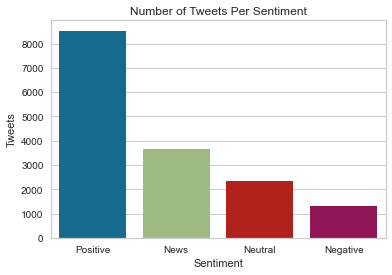

In [265]:
#  visualiing the number of tweets per class
fig = sns.barplot(x = ['Positive', 'News', 'Neutral', 'Negative'],y = group['message']) 
fig.set_xlabel('Sentiment')#x axis labels
fig.set_ylabel('Tweets')#y axis labels
fig.set_title('Number of Tweets Per Sentiment') #title

### Predictor Analysis



## Feature Extraction


In [297]:
# Create a function that cleans the training data and prepares it for modelling
def preprocessing(string):
    
    # Change the casing in the inputted string to lowercase
    string = string.lower()
    
    # Remove url addresses from the string
    string = re.sub(r"http\S+", "", string)
    
    # Instantiate TweetTokenizer with an argument that allows for the stripping of twitter handles
    tknzr = TweetTokenizer(strip_handles = True)
    
    # Tokenize the string using TweetTokenizer in order to remove twitter handles
    string = tknzr.tokenize(string)
    
    # Join the tokenized words together into sentences 
    string = " ".join(string)
    
    # Remove punctuation from the string 
    string = re.sub(r'[^a-z0-9\s]', '', string)
    string = re.sub(r'[0-9]+', '', string) # replace numbers or number like words with 'number'
    
    # Remove rt from the string
    message = re.sub(r'^rt', '', string)
    
    # Return a new string which has been cleaned of noise
    return message

###  CountVectorizer

In [298]:
# Create a copy our the training data set, train_data, which will be used to build the models
train_data = train.copy()
train_data.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [299]:
train_data['message']

0        PolySciMajor EPA chief doesn't think carbon di...
1        It's not like we lack evidence of anthropogeni...
2        RT @RawStory: Researchers say we have three ye...
3        #TodayinMaker# WIRED : 2016 was a pivotal year...
4        RT @SoyNovioDeTodas: It's 2016, and a racist, ...
                               ...                        
15814    RT @ezlusztig: They took down the material on ...
15815    RT @washingtonpost: How climate change could b...
15816    notiven: RT: nytimesworld :What does Trump act...
15817    RT @sara8smiles: Hey liberals the climate chan...
15818    RT @Chet_Cannon: .@kurteichenwald's 'climate c...
Name: message, Length: 15819, dtype: object

In [300]:
# sentiment column in the dataframe, train_data
y = train_data.sentiment
# message column in the dataframe, train_data
predictors = train_data.message 

In [301]:
y

0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

In [304]:
predictors

0        PolySciMajor EPA chief doesn't think carbon di...
1        It's not like we lack evidence of anthropogeni...
2        RT @RawStory: Researchers say we have three ye...
3        #TodayinMaker# WIRED : 2016 was a pivotal year...
4        RT @SoyNovioDeTodas: It's 2016, and a racist, ...
                               ...                        
15814    RT @ezlusztig: They took down the material on ...
15815    RT @washingtonpost: How climate change could b...
15816    notiven: RT: nytimesworld :What does Trump act...
15817    RT @sara8smiles: Hey liberals the climate chan...
15818    RT @Chet_Cannon: .@kurteichenwald's 'climate c...
Name: message, Length: 15819, dtype: object

In [305]:
# Instantiate CountVectorizer with the ngrams argument as cv
cv = CountVectorizer(ngram_range =(1,2))
# Use cv to vectorize the text data in the message columnn of the dataframe, creating a new vector, X
X = cv.fit_transform(predictors)

###  Train Test Split

In [306]:
# Train test split is called on the variables X and y to create a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

The data after splitting:

##  Model Training

###  Logistic Regression Classifier

In [307]:
# Instantiate the Logistic Regression model as logreg
logreg = LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42) 

In [308]:
# Fit the model to our training data
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [309]:
# Make predictions on the validation set
y_logreg = logreg.predict(X_val)

####  Model Performance

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

In [310]:
# Define the labels to be used in the confusion matrix
true_labels = ['true : Anti', 'true : Neutral', 'true : Pro', 'true : News']
pred_labels = ['pred : Anti', 'pred : Neutral', 'pred : Pro', 'pred : News']
type_labels = ['-1 : Anti', '0 : Neutral', '1 : Pro', '2 : News']

In [311]:
# Create the confusion matrix dataframe to visualise the number of correctly predicted observations
pd.DataFrame(data = confusion_matrix(y_val, y_logreg), index = true_labels, columns = pred_labels)

,pred : Anti,pred : Neutral,pred : Pro,pred : News
true : Anti,118,49,101,10
true : Neutral,13,197,186,29
true : Pro,13,69,1542,131
true : News,6,11,124,565


In [312]:
# Create a classification report from the validation set
logreg_report = classification_report(y_val, y_logreg, target_names=type_labels)

# Print out the classification report 
print(logreg_report)

              precision    recall  f1-score   support

   -1 : Anti       0.79      0.42      0.55       278
 0 : Neutral       0.60      0.46      0.52       425
     1 : Pro       0.79      0.88      0.83      1755
    2 : News       0.77      0.80      0.78       706

    accuracy                           0.77      3164
   macro avg       0.74      0.64      0.67      3164
weighted avg       0.76      0.77      0.76      3164



The imbalance in the data is evident in the classification report scores.  

**F1 Score**

In [313]:
f1_score_logreg = f1_score(y_val,y_logreg,average ="weighted") 
print(f'This is the accuracy for the basic LogisticRegression classifier: {f1_score_logreg}')

This is the accuracy for the basic LogisticRegression classifier: 0.7552303135207981


###  SMOTE Logistic Regression Classifier

In [314]:
# Instantiate SMOTE as sm
sm = SMOTE(random_state = 42) 

In [315]:
# Fit the SMOTE model on the training data
X_res, y_res = sm.fit_resample(X_train, y_train) 

In [316]:
# Instantiate a Logistic Regression model to use with the resampled data as logreg_smote 
logreg_smote = LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42)

In [317]:
# Fit the logistic regression model on the resampled data
logreg_smote.fit(X_res, y_res)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [318]:
# Predict on the validation set
y_logreg_smote = logreg_smote.predict(X_val)

####  Model Performance 

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

**Confusion Matrix**

In [319]:
# Create a confusion matrix on the validation data
pd.DataFrame(data = confusion_matrix(y_val, y_logreg_smote), index = true_labels, columns = pred_labels)

,pred : Anti,pred : Neutral,pred : Pro,pred : News
true : Anti,155,49,62,12
true : Neutral,51,196,139,39
true : Pro,46,110,1409,190
true : News,15,9,90,592


**Classifiction Report** 

In [320]:
# classification report on the validation set
smote_report = classification_report(y_val, y_logreg_smote, target_names = type_labels)

# Print the classification report
print(smote_report)

              precision    recall  f1-score   support

   -1 : Anti       0.58      0.56      0.57       278
 0 : Neutral       0.54      0.46      0.50       425
     1 : Pro       0.83      0.80      0.82      1755
    2 : News       0.71      0.84      0.77       706

    accuracy                           0.74      3164
   macro avg       0.66      0.67      0.66      3164
weighted avg       0.74      0.74      0.74      3164



**F1 Score**

In [321]:
# Calcuate the f1 score on the validation set
f1_score_logreg_smote = f1_score(y_val, y_logreg_smote, average = "weighted")

# Print the f1 score
print(f'This is the accuracy for the basic LogisticRegression classifier: {f1_score_logreg_smote}')

This is the accuracy for the basic LogisticRegression classifier: 0.7407898575509724


**Comparison**

In [322]:
# Create a dataframe to show the f1 scores of the basic logistic regression model vs the smote logistic regression model

# Create a list of f1 scores
f1_scores = [f1_score_logreg, f1_score_logreg_smote]

# Create a list to use as row labels
models = ["logreg(no smote)","logreg(with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

# Display the first 5 rows of the new dataframe
model_df.head()

,f1_score
logreg(no smote),0.75523
logreg(with smote),0.74079


###   Support Vector Classifier

In [372]:
# Instantiate the support vector classifier model as svm_clf 
svm_clf = SVC(C = 12, gamma = 0.01)

In [373]:
# Fit the model on the training data
svm_clf.fit(X_train, y_train)

SVC(C=12, gamma=0.01)

In [374]:
# Predict on the validation set
y_svm_CV = svm_clf.predict(X_val)

#### Model Performance

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

**Confusion Matrix**

In [326]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, y_svm_CV), index = true_labels, columns = pred_labels)

,pred : Anti,pred : Neutral,pred : Pro,pred : News
true : Anti,119,48,104,7
true : Neutral,12,190,204,19
true : Pro,12,73,1547,123
true : News,2,12,128,564


**Classfication Report** 

In [327]:
# Print the classification report the validation set
print(classification_report(y_val, y_svm_CV, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.82      0.43      0.56       278
 0 : Neutral       0.59      0.45      0.51       425
     1 : Pro       0.78      0.88      0.83      1755
    2 : News       0.79      0.80      0.79       706

    accuracy                           0.76      3164
   macro avg       0.75      0.64      0.67      3164
weighted avg       0.76      0.76      0.75      3164



**F1 Score**

In [329]:
# Calculate the f1 score on the validation set
f1_score_svm = f1_score(y_val, y_svm_CV, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the basic Support Vector Machine classifier: {f1_score_svm}')

This is the accuracy for the basic Support Vector Machine classifier: 0.7541666798301556


###  SMOTE Support Vector Classifier

In [330]:
# Instantiate a support vector classifier model to use on the resampled data
svm_clf_CV_smote = SVC(C = 10, gamma = 0.01)

# Fit the model on the resampled data
svm_clf_CV_smote.fit(X_res,y_res)

SVC(C=10, gamma=0.01)

In [331]:
# Predict using the validation set
y_pred_svm_CV_smote = svm_clf_CV_smote.predict(X_val)

####  Model Performance

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

**Confusion Matrix**

In [332]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, y_pred_svm_CV_smote), index = true_labels, columns = pred_labels)

,pred : Anti,pred : Neutral,pred : Pro,pred : News
true : Anti,115,39,117,7
true : Neutral,31,166,208,20
true : Pro,35,65,1535,120
true : News,6,19,126,555


**Classification Report**

In [333]:
# Print the classification report the validation set
print(classification_report(y_val, y_pred_svm_CV_smote, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.61      0.41      0.49       278
 0 : Neutral       0.57      0.39      0.46       425
     1 : Pro       0.77      0.87      0.82      1755
    2 : News       0.79      0.79      0.79       706

    accuracy                           0.75      3164
   macro avg       0.69      0.62      0.64      3164
weighted avg       0.74      0.75      0.74      3164



**F1 Score**

In [334]:
# Calculate the f1 score on the validation set
f1_svm_CV_smote = f1_score(y_val, y_pred_svm_CV_smote, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the basic Support Vector Machine classifier: {f1_score_svm}')

This is the accuracy for the basic Support Vector Machine classifier: 0.7541666798301556


**Comparison**

In [335]:
# Create a dataframe to show the f1 scores of the basic support vector classifier model vs the smote support vector classifier
# model

# Create a list of f1 scores
f1_scores = [f1_score_svm, f1_svm_CV_smote]

# Create a list to use as row labels
models = ["svc(no smote)","svc(with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)
model_df.head()

,f1_score
svc(no smote),0.754167
svc(with smote),0.737016


### Naive Bayes Classifier

**Basic Concept**

In [336]:
# Instantiate the naive bayes model as nb
nb = MultinomialNB() 

In [337]:
# Fit the model on the training data
nb.fit(X_train, y_train)

MultinomialNB()

In [338]:
# Predict on the validation data
pred_nb = nb.predict(X_val)

#### Model Performance

**Confusion Matrix**

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

In [339]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, pred_nb), index = true_labels, columns = pred_labels)

,pred : Anti,pred : Neutral,pred : Pro,pred : News
true : Anti,54,35,172,17
true : Neutral,8,132,239,46
true : Pro,4,31,1553,167
true : News,1,2,117,586


In [340]:
# Print the classification on the validation set
print(classification_report(y_val, pred_nb, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.81      0.19      0.31       278
 0 : Neutral       0.66      0.31      0.42       425
     1 : Pro       0.75      0.88      0.81      1755
    2 : News       0.72      0.83      0.77       706

    accuracy                           0.73      3164
   macro avg       0.73      0.55      0.58      3164
weighted avg       0.73      0.73      0.71      3164



In [341]:
# Calculate the f1 score on the validation set
f1_nb = f1_score(y_val, pred_nb, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the Naive Bayes classifier: {f1_score_svm}')

This is the accuracy for the Naive Bayes classifier: 0.7541666798301556


###  SMOTE Naive Bayes Classifier

In [342]:
# Instantiate the naive bayes classifier as nb_smote to use on the resampled data
nb_smote = MultinomialNB()

In [343]:
# Fit the model on the resampled data
nb_smote.fit(X_res, y_res)

MultinomialNB()

In [344]:
# Predict of the validation set
pred_nbsmote = nb_smote.predict(X_val)

####  Model Performance

**Confusion Matrix**

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

In [345]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, pred_nbsmote), index = true_labels, columns = pred_labels)

,pred : Anti,pred : Neutral,pred : Pro,pred : News
true : Anti,145,41,80,12
true : Neutral,49,179,146,51
true : Pro,64,90,1355,246
true : News,16,9,66,615


In [346]:
# Print the classification report of the validation set
print(classification_report(y_val, pred_nbsmote, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.53      0.52      0.53       278
 0 : Neutral       0.56      0.42      0.48       425
     1 : Pro       0.82      0.77      0.80      1755
    2 : News       0.67      0.87      0.75       706

    accuracy                           0.73      3164
   macro avg       0.64      0.65      0.64      3164
weighted avg       0.73      0.73      0.72      3164



In [347]:
# Calculate the f1 score on the validation set
f1_nb_smote = f1_score(y_val, pred_nbsmote, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the Naive Bayes classifier: {f1_score_svm}')

This is the accuracy for the Naive Bayes classifier: 0.7541666798301556


In [348]:

# Create a list of f1 scores
f1_scores = [f1_nb, f1_nb_smote]

# Create a list to use as row labels
models = ["NB (no smote)","NB (with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

model_df.head()

,f1_score
NB (no smote),0.705187
NB (with smote),0.721023


##  Test Data


In [365]:
# Create a copy of the test to perform noise cleaning and vectorization on
test_data = test.copy()

In [367]:
# Use CountVector in order to encode the words in the clean test dataframe
test_cv_trans =  cv.transform(test_data['message'])

# Print out the shape of the newly vectorized dataframe
print("The shape of the data is:", test_cv_trans.shape)

The shape of the data is: (10546, 148345)


###  Logistic Regression

In [352]:
# predict on test_data
y_pred_logreg_sub = logreg.predict(test_cv_trans)

####  Logistic Regression Submission

In [353]:
# Extract the tweetid column from test_data to use as the submission file index
tweetid = test_data['tweetid']

In [354]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_logreg = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_logreg_sub})

In [355]:
# Display the last 5 rows of the submission file
submission_logreg.tail()

,tweetid,sentiment
10541,895714,1
10542,875167,1
10543,78329,0
10544,867455,0
10545,470892,1


In [356]:
# Save dataframe to a csv file for submission
submission_logreg.to_csv("XOLANE_MANDLAZI1.csv", index = False)

###  Support Vector

In [375]:
# predict on test_data
y_pred_svm_sub = svm_clf.predict(test_cv_trans)

####  Support Vector Submission

In [376]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_svc = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_svm_sub})

In [377]:
# Display the last 5 rows of the submission file
submission_svc.tail()

,tweetid,sentiment
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0
10545,470892,1


In [378]:
# Save dataframe to a csv file for submission
submission_svc.to_csv("XOLANE MANDLAZI_FINAL.csv", index = False)

###  Naive Bayes

In [361]:
y_pred_nb = nb.predict(test_cv_trans)

#### 8.3.1. Naive Bayes Submission

In [362]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_nb = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_nb})

In [363]:
# Display the last 5 rows of the submission file
submission_nb.tail()

,tweetid,sentiment
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,0
10545,470892,1


In [364]:
# Save dataframe to a csv file for submission
submission_nb.to_csv("XOLANE_MANDLAZI3.csv", index = False)